## Experiment Setup

###  Random seed / Colab / CUDA related

In [0]:
import time
import datetime
import sys
import os

# Use Google Colab
use_colab = True

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')
    
    # If there's a package I need to install separately, do it here
    !pip install pyro-ppl

    # cd to the appropriate working directory under my Google Drive
    %cd 'drive/My Drive/Colab Notebooks/bayesian-dl-experiments'
    
    # List the directory contents
    !ls

# IPython reloading magic
%load_ext autoreload
%autoreload 2

# Random seeds
# Based on https://pytorch.org/docs/stable/notes/randomness.html
random_seed = 682

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/bayesian-dl-experiments
experiment_comparison_toy.ipynb  LICENSE    ronald_bdl
experiment_nn_capacity_1.ipynb	 README.md  test_results


### Third party libraries (NumPy, PyTorch, Pyro)

In [0]:
# Third party libraries import
import numpy as np
import torch
import pyro
import matplotlib.pyplot as plt

# Print version information
print("Python Version: " + sys.version)
print("NumPy Version: " + np.__version__)
print("PyTorch Version: " + torch.__version__)
print("Pyro Version: " + pyro.__version__)

Python Version: 3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]
NumPy Version: 1.17.4
PyTorch Version: 1.3.1
Pyro Version: 1.0.0


In [0]:
# More imports...
from torch.utils.data import random_split, DataLoader
from ronald_bdl import datasets, models
from pyro.infer import SVI, Trace_ELBO, HMC, MCMC

# pyplot setting
%matplotlib inline

# torch.device / CUDA Setup
use_cuda = True

if use_cuda and torch.cuda.is_available():
    torch_device = torch.device('cuda')

    torch.backends.cudnn.deterministic = True
    # Disable 'benchmark' mode
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    use_pin_memory = True # Faster Host to GPU copies with page-locked memory

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))
    print("CUDA Capabilities: "+ str(torch.cuda.get_device_capability()))
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False

CUDA Version: 10.1.243
cuDNN Version: 7603
CUDA Device Name: Tesla P100-PCIE-16GB
CUDA Capabilities: (6, 0)


### Toy dataset settings

In [0]:
"""
Toy dataset generation based on the experiment from 
the Probabilstic Backpropagation paper (Hernandez-Lobato & Adams, 2015)
"""

# Random seed for toy dataset
dataset_toy_random_seed = 691

# Toy dataset size
dataset_toy_size = 20

# Toy dataset x distribution (uniform) parameters
dataset_toy_x_low = -4
dataset_toy_x_high = 4

# Toy dataset y distribution (normal with noise)
dataset_toy_y_mean = 0
dataset_toy_y_std = 9

### MC dropout parameters

In [0]:
"""
MC Dropout related
"""

# Dropout rate
dropout_rate = 0.5

# L2 regularization strength
reg_strength = 0.3

# Epochs
n_epochs = 4000

# Optimizer learning rate
learning_rate = 0.01

# Loss function type
loss_function_type = 'mse_loss'

# Number of test predictions (for each data point)
n_predictions = 10000

### Directory path to save results

In [0]:
# Test start time
test_start_time = datetime.datetime.today().strftime('%Y%m%d%H%M')

# Directory to store the results for this experiment
test_results_path = os.path.join(
    './test_results',
    'comparison_toy',
    (
        test_start_time 
        + '_' + str(n_epochs) 
        + '_' + str(dropout_rate) 
        + '_' + str(reg_strength) 
        + '_' + str(loss_function_type) 
        + '_' + str(n_predictions))
)

# Create the directory if it doesn't exist
os.makedirs(test_results_path, exist_ok=True)

## Prepare data

### Get the data as a torch Dataset object

In [0]:
dataset = datasets.ToyDatasets(
    random_seed=dataset_toy_random_seed,
    n_samples=dataset_toy_size,
    x_low=dataset_toy_x_low,
    x_high=dataset_toy_x_high,
    y_mean=dataset_toy_y_mean,
    y_std=dataset_toy_y_std,
)

# Get the test data
X_test = torch.linspace(dataset_toy_x_low, dataset_toy_x_high, 100).reshape(100, 1)

# Send it to the memory of the device to be used for training
X_test = X_test.to(torch_device)

# Save a copy at CPU for plotting
X_test_cpu = X_test.cpu()

# Print the size of the training set
print("dataset size = " + str((len(dataset), dataset.n_features)))

dataset size = (20, 1)


## Declare models

In [0]:
uncertainty_methods = {}

# MC (Bernoulli) dropout
uncertainty_methods['mc_dropout'] = models.FCNetMCDropout(
    input_dim=dataset.n_features, 
    output_dim=dataset.n_targets,
    hidden_dim=100,
    n_hidden=0,
    dropout_rate=dropout_rate,
    dropout_type='bernoulli',
)

# Vanilla Variational Inference
uncertainty_methods['vi'] = models.FCNetPyro(
    input_dim=dataset.n_features, 
    output_dim=dataset.n_targets,
    hidden_dim=100,
    n_hidden=0,
    torch_device=torch_device,
)

# HMC (NUTS)
uncertainty_methods['hmc'] = models.FCNetPyro(
    input_dim=dataset.n_features, 
    output_dim=dataset.n_targets,
    hidden_dim=100,
    n_hidden=0,
    torch_device=torch_device,
)

## Train the models

### Train/test the model

In [9]:
for key, network in uncertainty_methods.items():
    # Reset the random number generator for each method (to produce identical results)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    pyro.set_rng_seed(random_seed)
    
    # Print the method name
    print("Now running " + str(key))
    
    # Send the whole model to the selected torch.device
    network.to(torch_device)

    # Print the network structure
    print(network)
    print()

    # Initialize training data loader
    train_loader = DataLoader(dataset, batch_size=len(dataset))
    
    """
    Optimizer Setup
    """

    if isinstance(network, models.FCNetMCDropout):
        # Adam optimizer
        # https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam
        # NOTE: Need to set L2 regularization from here
        optimizer = torch.optim.Adam(
            network.parameters(),
            lr=learning_rate,
            weight_decay=reg_strength, # L2 regularization
        )

        # Mean Squared Error for loss function to minimize
        objective = torch.nn.MSELoss()

    elif isinstance(network, models.FCNetPyro):
        # Clear everything in Pyro parameter storage
        # Looks like this parameter store would be globally shared across
        # models in the same Python instance.
        pyro.clear_param_store()

        # Force all the PyTorch tensors to be CUDA tensors if available
        if use_cuda and torch.cuda.is_available():
            torch.set_default_tensor_type(torch.cuda.FloatTensor)

        # Different optimizers for VI and HMC
        if key == 'vi':
            optimizer = pyro.optim.Adam({"lr": 0.03})
            svi = SVI(network, network.guide, optimizer, loss=Trace_ELBO())
        elif key == 'hmc':
            kernel = HMC(network)
            mcmc = MCMC(kernel, num_samples=30000)

    """
    Training
    """

    # Model to train mode
    network.train()

    # Record training start time (for this method)
    tic = time.time()
    
    if key == 'hmc':
        # to() actually returns new Tensor; need to replace with that return
        dataset.data_x = dataset.data_x.to(torch_device)

        dataset.data_y = dataset.data_y.to(torch_device)

        mcmc.run(dataset.data_x, dataset.data_y)
    else:
        for epoch in range(n_epochs): # loop over the dataset multiple times

            for i, data in enumerate(train_loader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, targets = data

                # Store the batch to torch_device's memory
                # to() actually returns new Tensor; need to replace with that return
                inputs = inputs.to(torch_device)
                targets = targets.to(torch_device)

                if isinstance(network, models.FCNetMCDropout):
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward + backward + optimize
                    outputs = network(inputs)

                    if loss_function_type in ('test_ll_mc', 'rmse_mc'):
                        _, _, _, metrics = network.predict_dist(
                            inputs, n_predictions, y_test=targets, reg_strength=reg_strength)

                        if loss_function_type == 'test_ll_mc':
                            total_loss = -(metrics[loss_function_type])
                    else:
                        total_loss = objective(outputs, targets)

                    total_loss.backward()

                    optimizer.step()

                elif isinstance(network, models.FCNetPyro):
                    pyro.clear_param_store()
                    # calculate the loss and take a gradient step
                    total_loss = svi.step(inputs, targets)

            if epoch % 100 == 0:
                print("[iteration %04d] loss: %.4f" % (epoch + 1, total_loss))
            
    # Record training end time
    toc = time.time()

    # Report the final loss
    print("final loss = " + str(total_loss))            

    # Report the total training time
    print("training time = " + str(toc - tic) + " seconds")
    
    print()

Now running mc_dropout
FCNetMCDropout(
  (input): ModuleDict(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear): Linear(in_features=1, out_features=100, bias=True)
    (relu): ReLU()
  )
  (output): Linear(in_features=100, out_features=1, bias=True)
)

[iteration 0001] loss: 567.4816
[iteration 0101] loss: 195.9487
[iteration 0201] loss: 149.9610
[iteration 0301] loss: 149.0002
[iteration 0401] loss: 95.3195
[iteration 0501] loss: 128.2759
[iteration 0601] loss: 142.6839
[iteration 0701] loss: 79.9381
[iteration 0801] loss: 84.8264
[iteration 0901] loss: 122.7435
[iteration 1001] loss: 79.0969
[iteration 1101] loss: 77.7390
[iteration 1201] loss: 94.7459
[iteration 1301] loss: 106.6193
[iteration 1401] loss: 85.4203
[iteration 1501] loss: 89.1049
[iteration 1601] loss: 84.2955
[iteration 1701] loss: 72.1902
[iteration 1801] loss: 97.9465
[iteration 1901] loss: 82.0757
[iteration 2001] loss: 87.9485
[iteration 2101] loss: 90.8747
[iteration 2201] loss: 69.4919
[iteration 2301] l

Warmup:   0%|          | 0/60000 [00:00, ?it/s]

final loss = 110375.73984372616
training time = 17.53402590751648 seconds

Now running hmc
FCNetPyro(
  (input): PyroModuleDict(
    (linear): PyroLinear(in_features=1, out_features=100, bias=True)
    (relu): PyroReLU()
  )
  (output): PyroLinear(in_features=100, out_features=1, bias=True)
  (guide): AutoDiagonalNormal()
)



Sample: 100%|██████████| 60000/60000 [24:18, 41.13it/s, step size=5.87e-01, acc. prob=0.889]


final loss = 110375.73984372616
training time = 1459.0506653785706 seconds



## Plot the results

testing time = 1.2815141677856445 seconds

Mean = tensor([-46.3057, -44.7380, -43.3662, -41.7774, -40.4026, -39.1493, -37.5199,
        -36.0282, -34.7524, -33.2765, -31.7272, -30.3479, -28.7960, -27.3311,
        -25.8971, -24.3806, -22.9718, -21.5608, -20.0655, -18.5634, -17.0789,
        -15.6141, -14.1956, -12.7407, -11.2717,  -9.8478,  -8.5073,  -7.2043,
         -6.2046,  -5.4789,  -4.8165,  -4.2686,  -3.8060,  -3.4262,  -3.0617,
         -2.7201,  -2.3939,  -2.1067,  -1.7932,  -1.4721,  -1.1700,  -0.8472,
         -0.5126,  -0.1576,   0.2013,   0.5589,   0.9204,   1.2786,   1.6285,
          1.9548,   2.2223,   2.4849,   2.6301,   2.7317,   2.8386,   2.9410,
          3.0394,   3.1513,   3.2487,   3.3595,   3.4648,   3.5729,   3.6763,
          3.7832,   3.8778,   3.9852,   4.0939,   4.1977,   4.2883,   4.4297,
          4.5658,   4.7131,   4.8323,   5.1018,   5.4239,   5.8439,   6.4378,
          7.3938,   8.5908,   9.9155,  11.3673,  12.8198,  14.4726,  16.3733,
         18.51

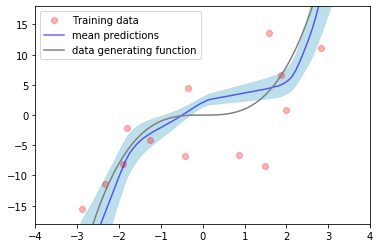

testing time = 6.360386848449707 seconds

Mean = tensor([-9.2009e+01, -9.0331e+01, -8.8492e+01, -8.6911e+01, -8.5094e+01,
        -8.3338e+01, -8.1606e+01, -7.9928e+01, -7.8163e+01, -7.6347e+01,
        -7.4649e+01, -7.2837e+01, -7.1113e+01, -6.9297e+01, -6.7605e+01,
        -6.5763e+01, -6.4158e+01, -6.2363e+01, -6.0582e+01, -5.8773e+01,
        -5.7091e+01, -5.5269e+01, -5.3575e+01, -5.1834e+01, -5.0137e+01,
        -4.8300e+01, -4.6501e+01, -4.4747e+01, -4.2961e+01, -4.1255e+01,
        -3.9637e+01, -3.7816e+01, -3.6022e+01, -3.4374e+01, -3.2628e+01,
        -3.0821e+01, -2.8895e+01, -2.7146e+01, -2.5340e+01, -2.3578e+01,
        -2.1246e+01, -1.8962e+01, -1.6763e+01, -1.4968e+01, -1.3299e+01,
        -1.1890e+01, -1.0313e+01, -9.3446e+00, -8.3020e+00, -7.3824e+00,
        -6.4950e+00, -5.7698e+00, -5.1764e+00, -4.3440e+00, -3.6058e+00,
        -3.1087e+00, -2.6261e+00, -2.3151e+00, -2.0405e+00, -1.9040e+00,
        -1.2264e+00, -7.6883e-01,  1.4005e-02,  3.7830e-01,  1.1278e+00,
  

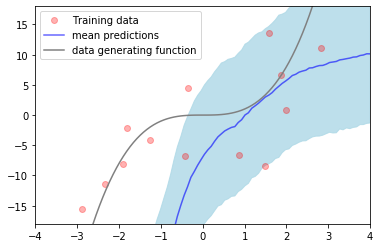

testing time = 6.451493263244629 seconds

Mean = tensor([ 33.4849,  32.7599,  32.1509,  31.5966,  30.9052,  30.2972,  29.6362,
         29.0467,  28.4441,  27.8094,  27.1654,  26.5234,  25.9194,  25.3078,
         24.7467,  24.1032,  23.5719,  22.9140,  22.4102,  21.8135,  21.4411,
         20.8337,  20.3079,  19.7022,  19.1294,  18.4166,  17.8490,  17.2149,
         16.7913,  16.0572,  15.7360,  15.1476,  14.5606,  13.9058,  13.1292,
         12.5651,  12.0041,  11.4037,  10.9103,  10.3422,   9.8329,   9.3329,
          8.8366,   8.4278,   7.7507,   7.0064,   6.1432,   5.3598,   4.5844,
          4.1311,   3.7582,   3.4268,   3.0803,   2.9500,   2.5097,   1.8730,
          1.4633,   1.1028,   0.1997,  -0.4835,  -1.1762,  -1.7917,  -2.5481,
         -3.1968,  -3.9011,  -4.6243,  -5.2817,  -5.8156,  -6.3835,  -6.9908,
         -7.4720,  -7.8835,  -8.3660,  -9.1719,  -9.6691, -10.4278, -11.0121,
        -11.6864, -12.2557, -12.6813, -13.2648, -13.5986, -13.9440, -14.3715,
        -14.774

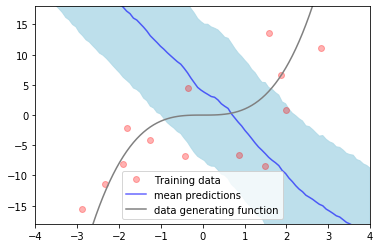

In [10]:
for key, network in uncertainty_methods.items():

    """
    Testing
    """

    # Model to eval mode
    network.eval()

    # Record testing start time (for this split)
    tic_testing = time.time()    

    predictions, mean, var, metrics = network.predict_dist(X_test, n_predictions)
    
    # Record testing end time
    toc_testing = time.time()
    
    # Report the total testing time
    print("testing time = " + str(toc_testing - tic_testing) + " seconds")

    # These can now be stored in CPU memory for plotting
    predictions = predictions.cpu()
    mean = mean.cpu()
    var = var.cpu()
    
    """
    Print results
    """

    print()
    print("Mean = " + str(mean.flatten()))
    print("Variance = " + str(var.flatten()))
    
    # store additional metrics
    if len(metrics) > 0:
        for key, value in metrics.items():
            print(str(key) + " = " + str(value))
        print()
             
    # Plot the uncertainty measured by each methods
    plt.figure()
    
    # Fix the scales of x-axis and y-axis
    plt.xlim(dataset_toy_x_low, dataset_toy_x_high)
    plt.ylim(dataset_toy_y_mean-2*dataset_toy_y_std, dataset_toy_y_mean+2*dataset_toy_y_std)

    # Distributions around the predictions
    plt.fill_between(
        X_test_cpu.flatten(), 
        (mean.detach().numpy() - 2*torch.sqrt(var).detach().numpy()).flatten(),
        (mean.detach().numpy() + 2*torch.sqrt(var).detach().numpy()).flatten(),
        color='lightblue', alpha=0.8)

    # Train data
    plt.plot(dataset.data_x.cpu(), dataset.data_y.cpu(), 'or', label='Training data', alpha=0.3)

    # MC prediction
    plt.plot(X_test_cpu, mean.detach().numpy(), 'blue', label='mean predictions', alpha=0.6)
    
    # Original data generating function without noise
    plt.plot(X_test_cpu, X_test_cpu ** 3, 'gray', label='data generating function')    
    
    plt.legend()
    
    plt.savefig(os.path.join(test_results_path, str(key) + '.png'))
    
    plt.show()